<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code/6_XGBoost_on_NO_SPQ_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this section of the code, we use the same machine learning methodology, in order to train an XGBoost model on traffic flow data that have been produced without the use of the SPQ algorithm.**


Previously, we generated a distinct traffic flow time series without implementing the SPQ algorithm. In this context, the absence of SPQ rules implies that, for a given path P comprising n edges, we ascertain that a moving object crosses the designated path within a specific time interval only when it successfully crosses all n edges of the path within this time interval.

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamp data types
from datetime import datetime, timedelta

In [2]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path with the data that we are interested in
PATH = '/content/drive/MyDrive/Paper/Timeseries/traffic_flow_without_SPQ.csv'

Mounted at /content/drive


**Prepare the dataset**

We use the necessary code to convert our time series dataframe into more usefull one.

In [3]:
# Read the time series dataset
traffic_flow_no_SPQ = pd.read_csv(PATH)

# This list contains the column names
columns = ["Taxi ID","Traj ID","Path","Length"]

# Generate the columns for the datasets
i =4
while(True):
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=1800))

    if (columns[i]>=pd.to_datetime('2008-05-30 00:00:04')):
        break

    i+=1

# Delete the last timestamp
columns.pop()

# Assign new column names to our dataframe
traffic_flow_no_SPQ.columns = columns

In [4]:
# Print dataframe
traffic_flow_no_SPQ

,Taxi ID,Traj ID,Path,Length,2008-05-17 10:00:04,2008-05-17 10:30:04,2008-05-17 11:00:04,2008-05-17 11:30:04,2008-05-17 12:00:04,2008-05-17 12:30:04,...,2008-05-29 19:00:04,2008-05-29 19:30:04,2008-05-29 20:00:04,2008-05-29 20:30:04,2008-05-29 21:00:04,2008-05-29 21:30:04,2008-05-29 22:00:04,2008-05-29 22:30:04,2008-05-29 23:00:04,2008-05-29 23:30:04
0,426,1539,"[88597575, 417101708, 417101708, 620169771, 62...",7,2,2,0,0,2,2,...,42,36,29,28,40,41,28,27,16,18
1,372,160,"[714016923, 713758735, 713758735, 713758728, 7...",19,4,1,2,0,0,3,...,2,1,1,2,1,2,3,2,0,1
2,262,190,"[1047613705, 1047613705, 527829987, 527829987,...",6,12,10,10,2,4,12,...,4,10,8,8,16,10,6,0,8,12
3,142,511,"[144346316, 144346316, 144346316]",3,110,106,95,90,33,52,...,289,263,407,287,266,164,278,182,184,185
4,181,484,"[734004334, 734004334, 734004334, 734004334, 7...",6,0,0,11,0,0,0,...,26,21,43,30,44,15,4,23,45,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,198,416,"[777343790, 225806055, 934194966, 934194966]",4,42,17,20,33,20,49,...,42,52,50,52,56,42,37,24,20,28
96,328,555,"[191297197, 191297197, 191297197, 437761157, 4...",20,0,0,0,14,14,0,...,0,0,0,14,0,0,8,0,0,8
97,305,41,"[286003244, 286003244, 286003244, 286003244, 2...",18,0,0,0,12,12,12,...,37,79,24,80,50,106,95,47,60,26
98,46,306,"[792350776, 408572570, 359898521, 359898521, 3...",10,0,1,2,0,1,1,...,6,6,10,8,9,11,10,5,5,4


In [5]:
# Reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = traffic_flow_no_SPQ.iloc[:,2:].columns
traffic_flow_no_SPQ = traffic_flow_no_SPQ.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
traffic_flow_no_SPQ['Time Column'] = pd.to_datetime(traffic_flow_no_SPQ['Time Column'])

# Sort rows by 'Path' and 'Time Column'
traffic_flow_no_SPQ.sort_values(by=['Path','Time Column'],inplace=True)

**Convert 'Path' column to numerical**

In [6]:
# Use label encoder
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
traffic_flow_no_SPQ['Path'] = label_encoder.fit_transform(traffic_flow_no_SPQ['Path'])

# Sort the data based in Path column
traffic_flow_no_SPQ = traffic_flow_no_SPQ.sort_values(by=['Path','Time Column'])

**Read and preprocess weather data**

In [7]:
# Define the path of weather data
path2 = '/content/drive/MyDrive/Paper/Datasets/Weather Data/weather_data.csv'

# Read weather data
weather_data = pd.read_csv(path2,sep=',')

# Keep only columns that are not highly correlated
weather_data = weather_data[['datetime','dew','temp','windspeed','cloudcover']]

# Convert datetime column to appropriate format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

In [8]:
# Connect two dataframes, time-series traffic flow and weather data
traffic_flow_no_SPQ.set_index('Time Column', inplace=True)
weather_data.set_index('datetime', inplace=True)

# Resample the 'weather_data' dataset to 30-minute intervals and forward-fill the missing values
weather_data = weather_data.resample('30T').ffill()

# Add 4 seconds to each timestamp
weather_data.index = weather_data.index + pd.to_timedelta(4, unit='s')

# Merge the 'traffic_flow_no_SPQ' and 'weather_data' datasets based on their indexes
traffic_flow_no_SPQ = traffic_flow_no_SPQ.merge(weather_data, left_index=True, right_index=True)

# Reset index and rename index column
traffic_flow_no_SPQ = traffic_flow_no_SPQ.reset_index()
traffic_flow_no_SPQ.rename(columns={'index': 'Time Column'}, inplace=True)

In [9]:
# Print dataframe
traffic_flow_no_SPQ

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,dew,temp,windspeed,cloudcover
0,2008-05-17 10:00:04,63,1079,0,7,10,11.8,21.4,12.1,28.1
1,2008-05-17 10:00:04,262,190,1,6,12,11.8,21.4,12.1,28.1
2,2008-05-17 10:00:04,45,32,2,14,10,11.8,21.4,12.1,28.1
3,2008-05-17 10:00:04,175,75,3,13,4,11.8,21.4,12.1,28.1
4,2008-05-17 10:00:04,173,176,4,17,0,11.8,21.4,12.1,28.1
...,...,...,...,...,...,...,...,...,...,...
60395,2008-05-29 23:30:04,52,910,95,8,13,8.9,13.2,14.2,93.6
60396,2008-05-29 23:30:04,264,188,96,20,1,8.9,13.2,14.2,93.6
60397,2008-05-29 23:30:04,10,222,97,5,4,8.9,13.2,14.2,93.6
60398,2008-05-29 23:30:04,212,553,98,3,30,8.9,13.2,14.2,93.6


**Feature Creation From Time Information**

In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [10]:
### Extract timestamp information to different columns ###

traffic_flow_no_SPQ['hour'] = traffic_flow_no_SPQ['Time Column'].dt.hour
traffic_flow_no_SPQ['dayofweek'] = traffic_flow_no_SPQ['Time Column'].dt.dayofweek
traffic_flow_no_SPQ['day'] = traffic_flow_no_SPQ['Time Column'].dt.day
traffic_flow_no_SPQ['minute'] = traffic_flow_no_SPQ['Time Column'].dt.minute

### Circular Encoding for cyclic time features ###

traffic_flow_no_SPQ['hour_sin'] = np.sin(2 * np.pi * traffic_flow_no_SPQ['hour'] / 24)
traffic_flow_no_SPQ['hour_cos'] = np.cos(2 * np.pi * traffic_flow_no_SPQ['hour'] / 24)

traffic_flow_no_SPQ['day_of_week_sin'] = np.sin(2 * np.pi * traffic_flow_no_SPQ['dayofweek'] / 7)
traffic_flow_no_SPQ['day_of_week_cos'] = np.cos(2 * np.pi * traffic_flow_no_SPQ['dayofweek'] / 7)

traffic_flow_no_SPQ['day_sin'] = np.sin(2 * np.pi * traffic_flow_no_SPQ['day'] / 31)
traffic_flow_no_SPQ['day_cos'] = np.cos(2 * np.pi * traffic_flow_no_SPQ['day'] / 31)

traffic_flow_no_SPQ['minute_sin'] = np.sin(2 * np.pi * traffic_flow_no_SPQ['minute'] / 60)
traffic_flow_no_SPQ['minute_cos'] = np.cos(2 * np.pi * traffic_flow_no_SPQ['minute'] / 60)

In [11]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Apply the custom function on the data to create the '3hour_interval' column
traffic_flow_no_SPQ['3hour_interval'] = traffic_flow_no_SPQ['hour'].apply(get_3hour_interval)

In [12]:
# Print dataframe
traffic_flow_no_SPQ

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,dew,temp,windspeed,cloudcover,...,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
0,2008-05-17 10:00:04,63,1079,0,7,10,11.8,21.4,12.1,28.1,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
1,2008-05-17 10:00:04,262,190,1,6,12,11.8,21.4,12.1,28.1,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
2,2008-05-17 10:00:04,45,32,2,14,10,11.8,21.4,12.1,28.1,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
3,2008-05-17 10:00:04,175,75,3,13,4,11.8,21.4,12.1,28.1,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
4,2008-05-17 10:00:04,173,176,4,17,0,11.8,21.4,12.1,28.1,...,0,0.500000,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60395,2008-05-29 23:30:04,52,910,95,8,13,8.9,13.2,14.2,93.6,...,30,-0.258819,0.965926,0.433884,-0.900969,-0.394356,0.918958,5.665539e-16,-1.0,8
60396,2008-05-29 23:30:04,264,188,96,20,1,8.9,13.2,14.2,93.6,...,30,-0.258819,0.965926,0.433884,-0.900969,-0.394356,0.918958,5.665539e-16,-1.0,8
60397,2008-05-29 23:30:04,10,222,97,5,4,8.9,13.2,14.2,93.6,...,30,-0.258819,0.965926,0.433884,-0.900969,-0.394356,0.918958,5.665539e-16,-1.0,8
60398,2008-05-29 23:30:04,212,553,98,3,30,8.9,13.2,14.2,93.6,...,30,-0.258819,0.965926,0.433884,-0.900969,-0.394356,0.918958,5.665539e-16,-1.0,8


#### **Find the optimum window length with the XGBoost model**


In [13]:
# Sort the time series data
traffic_flow_no_SPQ.sort_values(by=['Path','Time Column'], inplace=True)

In [14]:
# Define train data
train= traffic_flow_no_SPQ.loc[traffic_flow_no_SPQ['Time Column'] < '2008-05-29']

# Define test data
test = traffic_flow_no_SPQ.loc[traffic_flow_no_SPQ['Time Column'] >= '2008-05-29']

# Print the results
print("Traffic flow train set shape: ",train.shape)
print("Traffic flow test set shape: ",test.shape)

Traffic flow train set shape:  (55600, 23)
Traffic flow test set shape:  (4800, 23)


**Find the best lookback timesteps for our XGBoost model**

In this step, we define the optimum lookback timestep number for our sliding window. This optimum number will be used by the model for forecasting.

In [15]:
# Find best lookback timesteps to perform analysis on traffic_flow dataset. Save those scores in a separate dataframe
lookback_scores = pd.DataFrame(columns=['#Timesteps','XGBoost Score'])
lookback_scores['#Timesteps'] = 0
lookback_scores['XGBoost Score'] = 0

**Create function that converts the data into a supervised problem**

Consider for each path n_in timesteps of observations in the past, in order to predict the n_out timesteps in the future.

In [16]:
# Create function for generating (X, y) pairs
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Record %d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Record %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Record %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data,n_in=1,n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the culumns.
    """
    new_data = pd.DataFrame()
    for item in data['Path'].unique():

        # Call function only for traffic flow columns
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # The rest of the columns are concatenated as they were
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, traffic_flow_no_SPQ[traffic_flow_no_SPQ['Path'] == item]], axis=1)

        new_data = pd.concat([new_data,supervised_traffic_flow])

    new_data.dropna(inplace=True)
    return new_data

Create a loop. In each loop, we are doing the following:
- 0. Convert train and test sets into supervised problems with lookback timesteps.
- 1. Define features and labels.
- 2. Train the XGboost model with defult parameters.
- 3. Predict on the test set.
- 4. Save RMSE in a dataframe.

In [17]:
# Import libraries to use XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [18]:
for lookback in [2,3,4,5,6]: # Use different lookback sizes

    # Convert train and test data to supervised
    train_s = generate_X_y_pairs(train,lookback)
    test_s = generate_X_y_pairs(test,lookback)

    print("Lookback = "+str(lookback)+" - To supervised: Completed!")

    # Add rolling mean information
    train_s['rolling_mean'] = 0
    test_s['rolling_mean'] = 0

    train_s['rolling_mean'] = train_s.iloc[:,0:lookback].mean(axis=1)
    test_s['rolling_mean'] = test_s.iloc[:,0:lookback].mean(axis=1)

    # Define features
    features_s = train_s.drop(['Traffic Flow','Record 1(t)', 'Time Column'],axis=1).columns

    # Define label
    labels_s = ['Record 1(t)']

    # Create X_train and y_train datasets
    X_train_s = train_s[features_s]
    y_train_s = train_s[labels_s]

    # Create X_test and y_test datasets
    X_test_s = test_s[features_s]
    y_test_s = test_s[labels_s]

    print("Lookback = "+str(lookback)+" - Train and Test sets: Completed!")

    # Define XGBoost regression model
    reg = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100,early_stopping_rounds = 5)

    # Train the XGBoost model with feature weights (use validation set on test data)
    reg.fit(X_train_s, y_train_s, eval_set=[(X_train_s, y_train_s), (X_test_s,y_test_s)],verbose=False)

    print("Lookback = "+str(lookback)+" - Trainning: Completed!")

    # Make predictions
    y_pred_s = reg.predict(X_test_s)

    # Calculate RMSE score
    rmse = mean_squared_error(y_test_s, y_pred_s, squared=False)

    # Create a new row as a dictionary
    new_row = {'#Timesteps': lookback, 'XGBoost Score': rmse}

    # Append the new row to the DataFrame
    lookback_scores = lookback_scores.append(new_row, ignore_index=True)

    print("Lookback = "+str(lookback)+" - Saved Results: Completed!")

Lookback = 2 - To supervised: Completed!
Lookback = 2 - Train and Test sets: Completed!
Lookback = 2 - Trainning: Completed!
Lookback = 2 - Saved Results: Completed!
Lookback = 3 - To supervised: Completed!
Lookback = 3 - Train and Test sets: Completed!
Lookback = 3 - Trainning: Completed!
Lookback = 3 - Saved Results: Completed!
Lookback = 4 - To supervised: Completed!
Lookback = 4 - Train and Test sets: Completed!
Lookback = 4 - Trainning: Completed!
Lookback = 4 - Saved Results: Completed!
Lookback = 5 - To supervised: Completed!
Lookback = 5 - Train and Test sets: Completed!
Lookback = 5 - Trainning: Completed!
Lookback = 5 - Saved Results: Completed!
Lookback = 6 - To supervised: Completed!
Lookback = 6 - Train and Test sets: Completed!
Lookback = 6 - Trainning: Completed!
Lookback = 6 - Saved Results: Completed!


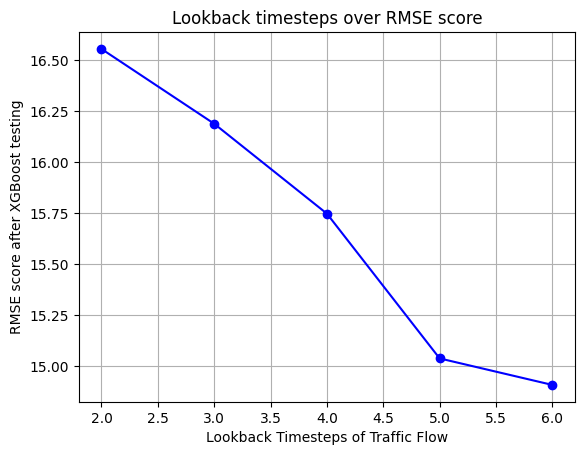

In [19]:
# Use a plot to show the results
plt.plot(lookback_scores['#Timesteps'], lookback_scores['XGBoost Score'], linestyle='-', marker='o', color='b')

# Set plot title and axis labels
plt.title('Lookback timesteps over RMSE score')
plt.xlabel('Lookback Timesteps of Traffic Flow')
plt.ylabel('RMSE score after XGBoost testing')

# Add gridlines
plt.grid(True)

# Show the plot
plt.show()

In [20]:
# Find the timesteps corresponding to the minimum RMSE score
optimum_lookback = int(lookback_scores['#Timesteps'].loc[lookback_scores['XGBoost Score'].idxmin()])

In [21]:
# Print optimum length of sliding window
print(f'Optimum length of sliding window is: {optimum_lookback}')

Optimum length of sliding window is: 6


In [22]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

**Extract features about trend of time series**

In this step we define the rolling mean and rolling variance of a window. Since we are trying to forecast the last value of each window, only the first optimum_lookback values in the window are used to compute rolling features. The last value (that we are trying to forecast) is not included.

In [23]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:optimum_lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

**Define labels and features**

- Features will help the XGboost algorithm to predict the output value (the label). We will use all the traffic flow information at previous timesteps (t-n,t-n+1...,t-2,t-1), as well as the rest of the features (time and trend information) as features.

- Label will be out target value, the Traffic Flow at timestep t.

<Axes: >

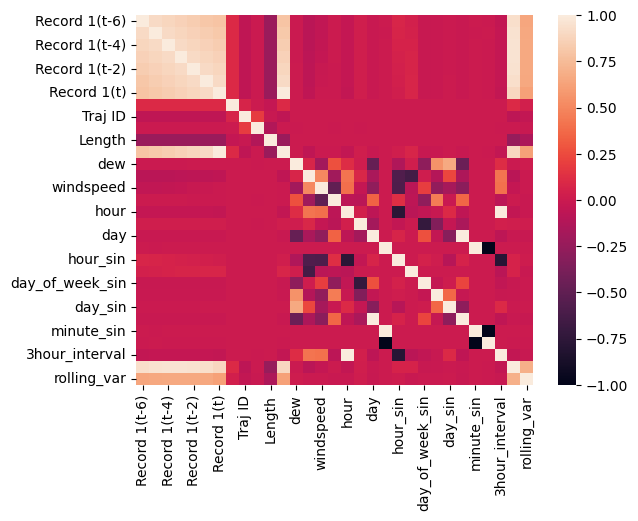

In [24]:
# Use a correlation matrix to show correlations among attributes in the dataset
sns.heatmap(train.corr(),cmap='rocket')

In [25]:
# Define a list with the items to be removed
removable_items = ['Record 1(t)', 'Time Column', 'Taxi ID', 'Traj ID', 'Length', 'Traffic Flow', 'hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute', 'minute_cos']

In [26]:
# Define features
features = train.drop(removable_items,axis=1).columns
# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

In [27]:
# Show shape information about X and y training and testing sets
print("Shape of X_train is: ",X_train.shape)
print("Shape of y_train is: ",y_train.shape)
print("Shape of X_test is: ",X_test.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of X_train is:  (55000, 19)
Shape of y_train is:  (55000, 1)
Shape of X_test is:  (4200, 19)
Shape of y_test is:  (4200, 1)


**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [28]:
# Import Grid Search library
from sklearn.model_selection import GridSearchCV

In [29]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        verbose=1,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[0]	validation_0-rmse:39.84061	validation_1-rmse:37.57854
[1]	validation_0-rmse:36.71033	validation_1-rmse:34.51696
[2]	validation_0-rmse:33.96486	validation_1-rmse:31.95036
[3]	validation_0-rmse:31.51561	validation_1-rmse:29.64650
[4]	validation_0-rmse:29.36154	validation_1-rmse:27.60762
[5]	validation_0-rmse:27.44121	validation_1-rmse:25.80990
[6]	validation_0-rmse:25.78068	validation_1-rmse:24.30754
[7]	validation_0-rmse:24.36594	validation_1-rmse:22.97267
[8]	validation_0-rmse:23.10561	validation_1-rmse:21.84555
[9]	validation_0-rmse:22.03456	validation_1-rmse:21.00442
[10]	validation_0-rmse:21.13720	validation_1-rmse:20.19967
[11]	validation_0-rmse:20.35931	validation_1-rmse:19.61982
[12]	validation_0-rmse:19.73295	validation_1-rmse:19.13316
[13]	validation_0-rmse:19.17561	validation_1-rmse:18.67319
[14]	validation_0-rmse:18.71303	validation_1-rmse:18.28758
[15]	validation_0-rmse:18.37998	validation_1-rmse:18.08053
[16]	

#### **Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [30]:
# Create dataframe to save actual values and model predictions
total_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
total_predictions['Actual'] = y_test['Record 1(t)'].values
total_predictions['Path'] = X_test['Path'].values

In [31]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=True)

[0]	validation_0-rmse:39.81163	validation_1-rmse:37.52515
[1]	validation_0-rmse:36.69759	validation_1-rmse:34.50900
[2]	validation_0-rmse:33.94307	validation_1-rmse:31.83846
[3]	validation_0-rmse:31.50535	validation_1-rmse:29.47986
[4]	validation_0-rmse:29.37094	validation_1-rmse:27.43316
[5]	validation_0-rmse:27.48098	validation_1-rmse:25.65473
[6]	validation_0-rmse:25.84600	validation_1-rmse:24.06116
[7]	validation_0-rmse:24.40752	validation_1-rmse:22.71474
[8]	validation_0-rmse:23.17462	validation_1-rmse:21.54876
[9]	validation_0-rmse:22.10330	validation_1-rmse:20.56013
[10]	validation_0-rmse:21.16690	validation_1-rmse:19.73412
[11]	validation_0-rmse:20.37484	validation_1-rmse:19.01141
[12]	validation_0-rmse:19.70207	validation_1-rmse:18.41970
[13]	validation_0-rmse:19.12812	validation_1-rmse:17.94322
[14]	validation_0-rmse:18.64275	validation_1-rmse:17.53539
[15]	validation_0-rmse:18.23418	validation_1-rmse:17.20418
[16]	validation_0-rmse:17.88553	validation_1-rmse:16.89426
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Figure size 1500x500 with 0 Axes>

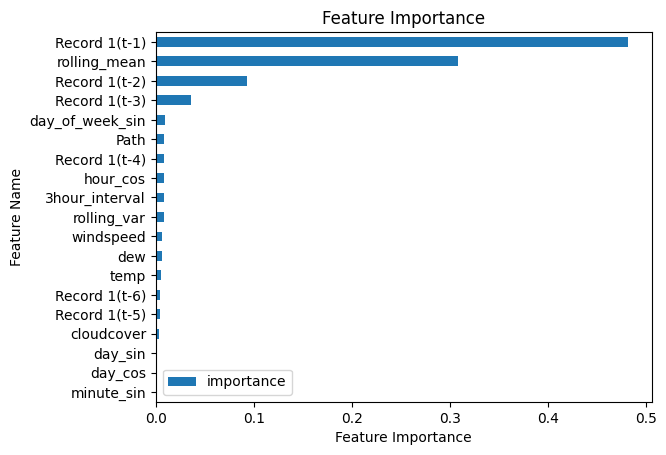

In [32]:
# Show how much each of the features was used in our regression analysis
plt.figure(figsize=(15,5))
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

Plot train and validation errors of XGBoost model in the same graph

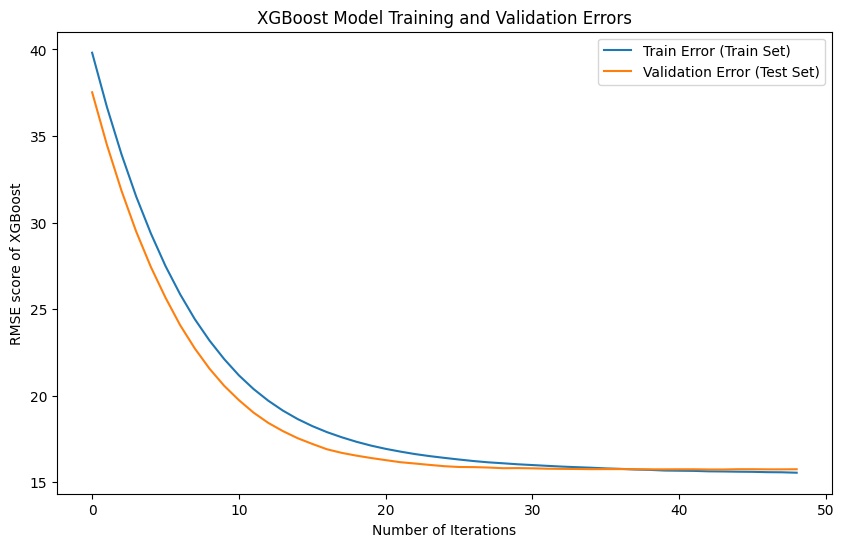

In [33]:
# Acquire the values of train and validation errors
results = reg.evals_result()
train_errors = results['validation_0']['rmse']
validation_errors = results['validation_1']['rmse']

# Plot the validation and training errors
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train Error (Train Set)')
plt.plot(validation_errors, label='Validation Error (Test Set)')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE score of XGBoost')
plt.title('XGBoost Model Training and Validation Errors')
plt.legend()
plt.show()

Make predictions on the test set

In [34]:
# Predict on the X_test, estimate the y_test values
y_pred_xgboost = reg.predict(X_test)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  6.790329058681215
RMSE score: 15.727098681273068


Show example of how well the model learned the trainning data.


Use a random path to visualize the results

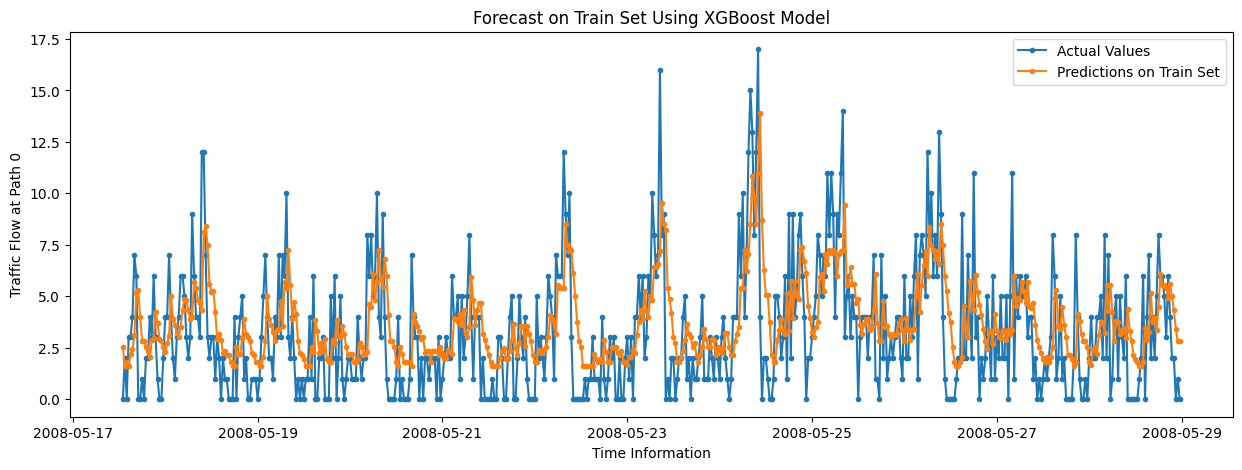

In [36]:
# Predict on the trainning set
y_pred_train = reg.predict(X_train)

# Add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Record 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train)
train_predictions.insert(2,'Path',X_train['Path'].values)

# Plot an example of the train-predictions at path 0 of the datase
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0]['Train Actual'],".-",label='Actual Values')
plt.plot(train_predictions[train_predictions['Path']==0]['Train Predicted'],".-",label='Predictions on Train Set')
plt.xlabel('Time Information')
plt.ylabel('Traffic Flow at Path 0')
plt.title('Forecast on Train Set Using XGBoost Model')
plt.legend()
plt.show()

As we can see, the model has learned the trend and (almost) the seasonality of the data.

Despite the non-linearity of Traffic Flow, XGBoost performs quite well!

In [37]:
# Store predictions of XGBoost model to a dataframe
total_predictions['Predicted XGBoost'] = y_pred_xgboost

In [38]:
# Print dataframe with predictions
total_predictions

,Actual,Path,Predicted XGBoost
Time Column,,,
2008-05-29 03:00:04,2.0,0,3.222051
2008-05-29 03:30:04,5.0,0,2.854709
2008-05-29 04:00:04,9.0,0,3.382010
2008-05-29 04:30:04,4.0,0,5.937065
2008-05-29 05:00:04,4.0,0,4.832949
...,...,...,...
2008-05-29 21:30:04,10.0,99,7.372636
2008-05-29 22:00:04,13.0,99,7.682730
2008-05-29 22:30:04,11.0,99,9.505473


[]

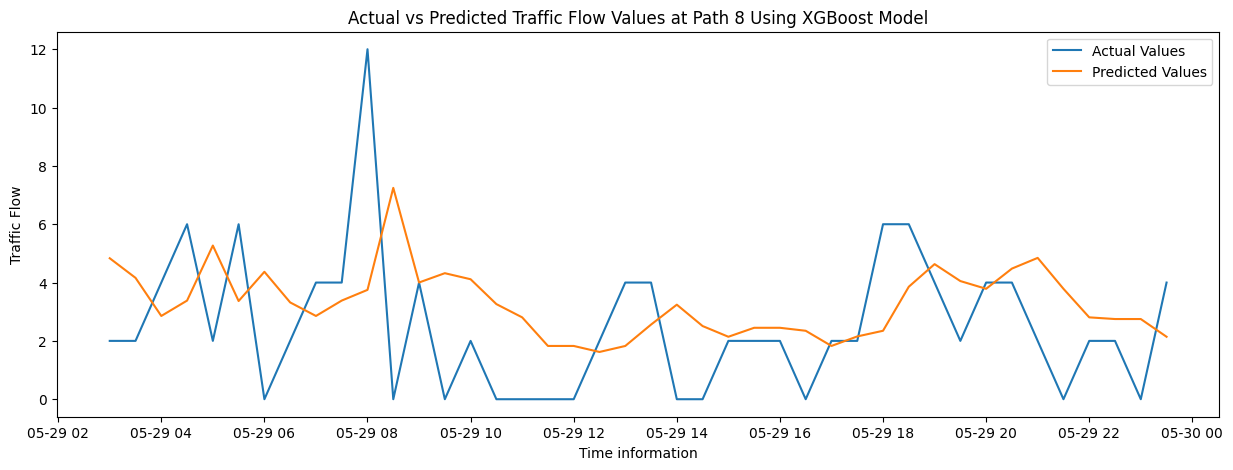

In [39]:
# Plot predictions for path 8
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==8]['Actual'],label='Actual Values')
plt.plot(total_predictions[total_predictions['Path']==8]['Predicted XGBoost'],label='Predicted Values')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow')
plt.title('Actual vs Predicted Traffic Flow Values at Path 8 Using XGBoost Model')
plt.legend()
plt.plot()

[]

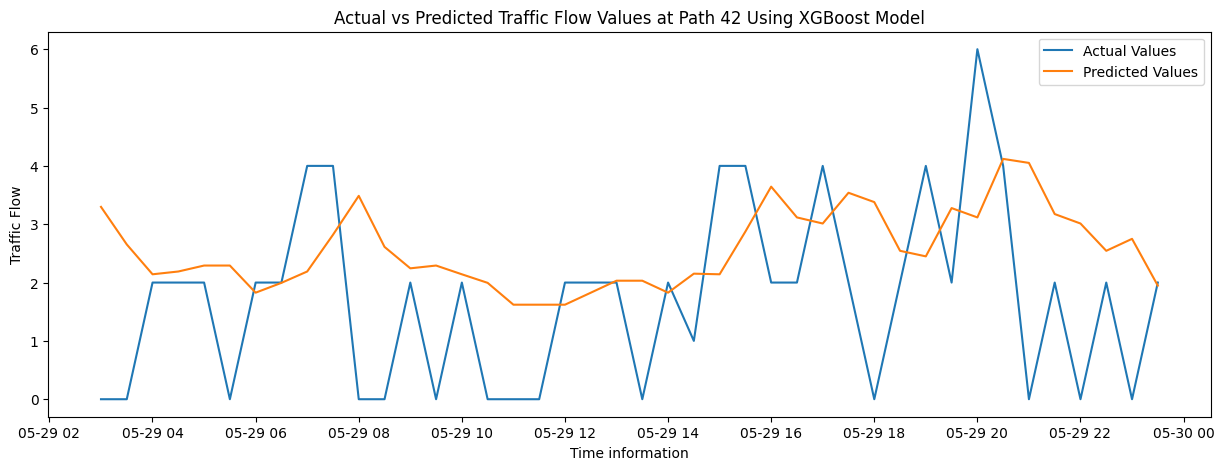

In [40]:
# Plot predictions for path 42
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==42]['Actual'],label='Actual Values')
plt.plot(total_predictions[total_predictions['Path']==42]['Predicted XGBoost'],label='Predicted Values')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow')
plt.title('Actual vs Predicted Traffic Flow Values at Path 42 Using XGBoost Model')
plt.legend()
plt.plot()

[]

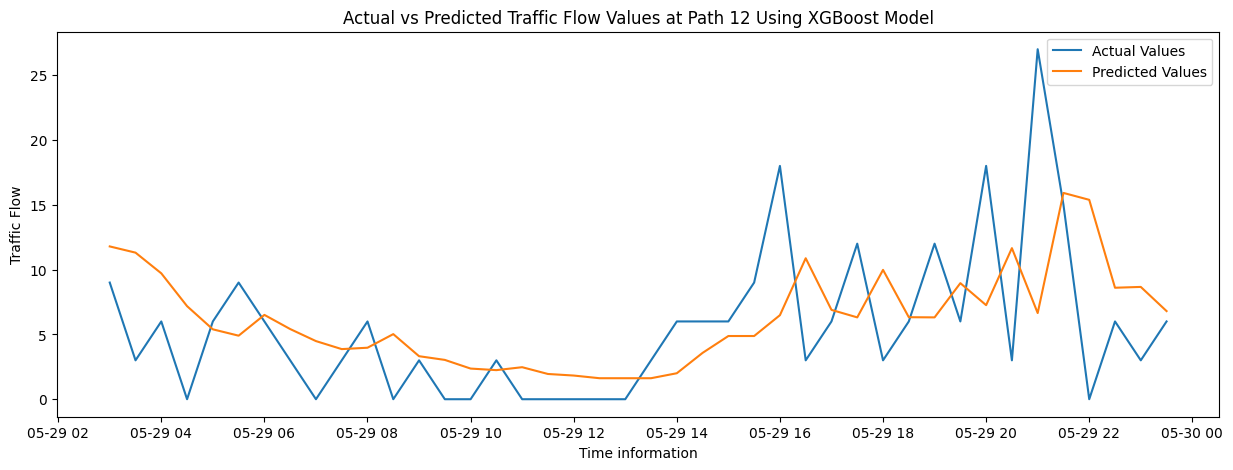

In [41]:
# Plot predictions for path 12
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==12]['Actual'],label='Actual Values')
plt.plot(total_predictions[total_predictions['Path']==12]['Predicted XGBoost'],label='Predicted Values')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow')
plt.title('Actual vs Predicted Traffic Flow Values at Path 12 Using XGBoost Model')
plt.legend()
plt.plot()

Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [42]:
# Create dataframe with scores
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)

# Print dataframe with all model scores
scores

,Model,RMSE Score,MAE Score
0,XGBoost,15.727099,6.790329


Conclusion

Data that have been collected without the SPQ rules tend to introduce noice. By this way, the best model that we defined before, strugles to understand the data and find patterns in them.